In [2]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

In [3]:
class SimCLR(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimCLRProjectionHead(512, 2048, 2048)
        self.criterion = NTXentLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

In [4]:
model = SimCLR()

transform = SimCLRTransform(input_size=32)
dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform, train=True
)

# ... or MNIST
# dataset = torchvision.datasets.MNIST(
#     "datasets/mnist-clean-torchvision", download=True, transform=transform
# )

# ... or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

Files already downloaded and verified


In [5]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator=accelerator)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
# training
# trainer.fit(model=model, train_dataloaders=dataloader)

# read from checkpoint
model = SimCLR.load_from_checkpoint(
    r"lightning_logs\version_15\checkpoints\epoch=9-step=1950.ckpt"
)

## Generate embeddings

In [7]:
import numpy as np
from utils import generate_embeddings
from lightly.transforms.utils import IMAGENET_NORMALIZE

In [8]:
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=IMAGENET_NORMALIZE["mean"],
            std=IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [9]:
# note, that this is not 'test' in a train/test sense
# SIMCLR is uses SSL method, so labels doesn't really matter
test_dataset = torchvision.datasets.CIFAR10(
    "datasets/test-cifar10", download=True, transform=test_transform, train=False
)

Files already downloaded and verified


In [10]:
len(dataset)

50000

In [11]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    # this is important!
    shuffle=False,
    drop_last=True,
    num_workers=8,
)

In [12]:
embeddings = generate_embeddings(model, test_dataloader)

In [13]:
print(type(embeddings))
print(len(embeddings))
print(embeddings.shape)

<class 'torch.Tensor'>
9984
torch.Size([9984, 512])


## Validate embeddings

In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [15]:
num_principal_components = 3
n_clusters = 20

In [16]:
pca = PCA(n_components=num_principal_components)
embeddings_reduced = pca.fit_transform(embeddings.to("cpu").numpy())

kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(embeddings_reduced)
centroids = kmeans.cluster_centers_

d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid

In [17]:
centroids.shape

(20, 3)

In [23]:
%matplotlib widget

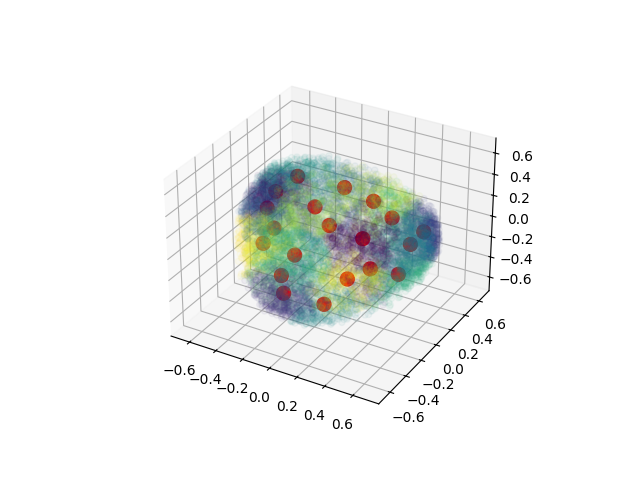

In [24]:
ax = plt.figure().add_subplot(projection="3d")

ax.scatter(
    embeddings_reduced[:, 0],
    embeddings_reduced[:, 1],
    embeddings_reduced[:, 2],
    c=labels,
    alpha=0.05,
)

ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    c="red",
    s=100,
    alpha=1.0,
)

plt.show()

## Misc

In [19]:
from utils import get_distances_between_centroids

In [20]:
distances = get_distances_between_centroids(embeddings.to("cpu").numpy(), n_clusters=20)

Cluster centroids dimensions: (20, 3)
Cluster centroids:
 [[-5.32939732e-01  1.88467354e-01  8.61179382e-02]
 [ 2.07604975e-01  4.56868291e-01 -1.57674640e-01]
 [ 6.50087893e-02 -5.03898025e-01 -5.12972591e-04]
 [ 5.04086137e-01 -4.37408723e-02  2.08815694e-01]
 [-2.86237091e-01 -1.23473391e-01 -4.09228921e-01]
 [-1.60843328e-01 -3.33373427e-01  3.27909708e-01]
 [ 6.86008949e-03 -3.71706605e-01 -3.87138665e-01]
 [ 2.12190270e-01 -3.52425456e-01  3.29736680e-01]
 [-4.02530044e-01 -2.79707368e-02  3.48501354e-01]
 [ 9.70654264e-02  3.63535807e-02  4.20304447e-01]
 [-2.58462522e-02  4.51503038e-01  1.39483243e-01]
 [ 5.56483090e-01  1.16073973e-01 -8.79795402e-02]
 [-4.72361296e-01 -1.12639032e-01  5.76149905e-03]
 [ 3.55508119e-01 -2.39106685e-01 -8.42505768e-02]
 [-1.95340857e-01  3.89308244e-01 -2.16152310e-01]
 [-3.42954427e-01  2.77744025e-01  2.70372242e-01]
 [ 4.69025165e-01  3.16334337e-01  1.04322806e-01]
 [-4.89165187e-01  1.58842385e-01 -2.37352371e-01]
 [-2.38821402e-01 -3.595

In [21]:
print(f"Distances shape: {distances.shape}")
print(f"Distances rank: {np.linalg.matrix_rank(distances)}")
print(f"Distancess:\n {distances}")

Distances shape: (20, 20)
Distances rank: 20
Distancess:
 [[0.         0.82454857 0.91892174 1.06976542 0.6352462  0.68500861
  0.91057703 0.95243574 0.36427626 0.72919526 0.5737416  1.10561875
  0.31747749 1.00059211 0.49565852 0.27931056 1.01025494 0.32776042
  0.64587007 0.91338825]
 [0.82454857 0.         0.98392346 0.68762328 0.8024687  0.99801217
  0.88288652 0.94474716 0.92927271 0.72326443 0.37792998 0.49266024
  0.90188918 0.71529546 0.41273398 0.72001756 0.39589515 0.76200829
  0.93305682 0.46264265]
 [0.91892174 0.98392346 0.         0.66959093 0.65965544 0.43353117
  0.41271694 0.39200913 0.75293449 0.68555578 0.96986843 0.7959665
  0.66474775 0.40189091 0.95503911 0.92237578 0.92032652 0.89578264
  0.34762397 0.69380781]
 [1.06976542 0.68762328 0.66959093 0.         1.00645279 0.73498408
  0.84258938 0.441714   0.91744955 0.46562697 0.72863012 0.3411358
  0.99971374 0.38227093 0.92591979 0.9080856  0.37656632 1.10754418
  0.86012025 0.64895735]
 [0.6352462  0.8024687  0.65

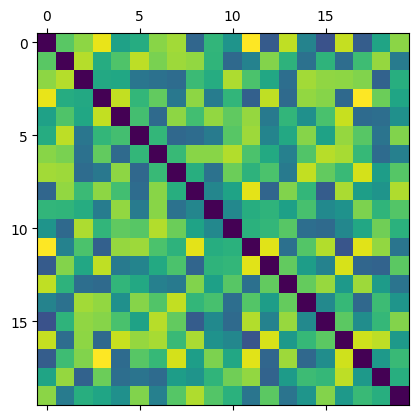

In [22]:
plt.matshow(distances, cmap="viridis")